In [93]:
# Most Code here
import sys
#Switch to deepliver
#if "/opt/caffe/python" in sys.path : sys.path.remove("/opt/caffe/python")
#if "/opt/deepliver/python" not in sys.path : sys.path.insert(0,"/opt/deepliver/python")

import plyvel, lutils, math, re
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import pandas
from PIL import Image,ImageFilter
plt.set_cmap('gray')
%matplotlib inline

def hist(arr):
    """Print number of pixels for each label in the given image (arr)"""
    return "%.3f , %.3f , %.3f, %.3f" % (np.sum(arr==0),np.sum(arr==1),np.sum(arr==2),np.sum(arr==4))

def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2)
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none', cmap=cmap)
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
        
def dice(prediction, segmentation, label_of_interest = 1):
    """ Takes 2 2-D arrays with class labels, and return a float dice score.
    Only label=label_of_interest is considered """
    if prediction.shape != segmentation.shape:
        raise ValueError("Shape mismatch between given arrays. prediction %s vs segmentation %s" \
                         % (str(prediction.shape), str(segmentation.shape)))

    n_liver_seg = np.sum(segmentation==label_of_interest)
    n_liver_pred= np.sum(prediction == label_of_interest)
    denominator = n_liver_pred + n_liver_seg
    if denominator == 0:
        return -1

    liver_intersection   = np.logical_and(prediction==label_of_interest, segmentation==label_of_interest)
    n_liver_intersection = np.sum(liver_intersection)

    dice_score = 2.0*n_liver_intersection / denominator
    return dice_score

def protobinary_to_array(filename, outpng=None):
    """ Filename is path to protobinary
    outpng is path to output png"""
    with open(filename,'r') as f:
        data = f.read()

    blob = caffe.proto.caffe_pb2.BlobProto()
    blob.ParseFromString(data)
    arr = np.array(caffe.io.blobproto_to_array(blob)) #returns shape (1,1,W,H)
    arr = arr[0,0,:,:] #ignore first 2 dimensions
    return  arr

dices_liver = []
dices_lesion= []
def predict(net, img, seg, meanimg, no_plot=False):
    """Predicts an img using the trained net, and compares it to the label image (seg)"""
    net.blobs['data'].data[0]=(img-meanimg)
    prob=net.forward()['prob'][0]
    prediction = np.argmax(prob,axis=0)
    dice_liver = dice(prediction,seg,label_of_interest=1)
    dice_lesion = dice(prediction,seg,label_of_interest=2)
    dices_liver.append(dice_liver)
    dices_lesion.append(dice_lesion)
    print "Dice Liver:", dice_liver
    print "Dice Lesion:",dice_lesion
    print "Prediction class histogram",hist(prediction)
    print "Ground truth class histogram",hist(seg)
    if not no_plot:
        plt.figure(figsize=(20,24))
        plt.subplot(1,3,1); plt.title("Image")
        plt.imshow(img)
        plt.subplot(1,3,2); plt.title("Ground truth")
        plt.imshow(seg)
        plt.subplot(1,3,3); plt.title("Prediction")
        plt.imshow(prediction)
        plt.show()
    return prediction
    
    
def read_imgs(dbimgit, dbsegit, n=1, print_keys=True):
    """Read img and label after skipping n keys in leveldb. Takes db iterators"""
    for _ in range(n):
        k1,vimg = dbimgit.next()
        k2,vseg = dbsegit.next()
    if print_keys:
        print "Keys:",k1,k2
    img=lutils.to_numpy_matrix(vimg)
    seg=lutils.to_numpy_matrix(vseg)
    return img,seg

def show_kernels(layer_blob_data, fast = False):
    """ Takes solver.net.params['conv1'][0].data and visualize the first channel of all kernels.
    If fast = False : subplots will be used, allowing to see each filter individually, but takes time.
    If fast = True : all filters are plotted in one image"""
    #Input has 4 dims, we only visualize 1st channel of each kernel 
    # (the conv weights that acts on the 1st channel of the input)
    data = layer_blob_data[:,0,:,:]
    if fast:
        raise NotImplementedError("todo")
    n_kernels = data.shape[0]
    plot_cols = 10 #number of images in one row
    plot_rows = math.ceil(n_kernels*1.0 / plot_cols)
    # Adjust figure plot size
    plt.figure(figsize=(min(plot_cols, n_kernels)*2, plot_rows*2))
    # Plot !
    for i in range(n_kernels):
        plt.subplot(plot_rows, plot_cols, i+1)
        plt.imshow(data[i], interpolation='none')
        
def plot_deepliver_log(fname):
    """Takes file handle of deepliver log, and plots the 4 plots :
    Loss, avgAccuracy, avgJaccard, avgRecall"""
    f = open(fname, 'r')
    logs = f.read()
    plt.figure(figsize=(10,10))
    # Get iterations
    iterations = re.findall("Iteration (\d+), loss",logs)

    # Get&plot loss
    loss = zip(*re.findall("Iteration \d+, loss = ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)",logs))[0]
    length = min(len(iterations), len(loss))
    iterations_trunc, loss_trunc = iterations[:length], loss[:length]
    plt.plot(iterations,loss,label='Loss')
    #plt.show()
    #Get&plot metrics
    metrics = ['Accuracy','Recall','Jaccard']
    data = defaultdict(list) # data.keys() = metrics , data[metrics[0]] = list of values
    for i,metric in enumerate(metrics):
        regex = "Train net output #"+str(i)+": accuracy = ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)"
        for result in re.findall(regex,logs):
            data[metric].append(result[0])

    for metric in data.keys():
        length = min(len(iterations),len(data[metric]))
        iterations_trunc, data_trunc = iterations[:length], data[metric][:length]
        plt.plot(iterations_trunc, data_trunc,label=metric)
        plt.legend(loc="lower center",prop={'size':15})
    f.close()


def histeq(im,nbr_bins=256):
    """Histogram equalization"""
    #get image histogram
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() #cumulative distribution function
    cdf = 255 * cdf / cdf[-1] #normalize
    #use linear interpolation of cdf to find new pixel values
    im2 = np.interp(im.flatten(),bins[:-1],cdf)
    return im2.reshape(im.shape)

Suppose our the ground truth is the following image in the middle

Keys: 00100_00096846_00083_img_xy_0349_15 00100_00096846_00083_seg_xy_0349_15
Dice Liver: 0.106579129407
Dice Lesion: -1
Prediction class histogram 0.000 , 150544.000 , 0.000, 0.000
Ground truth class histogram 142070.000 , 8474.000 , 0.000, 0.000


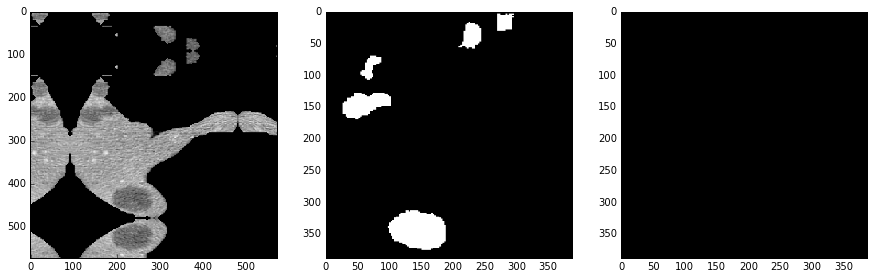

In [195]:
img,seg2 = read_imgs(dbimgit,dbsegit,1)
pred2 = predict(net,img,seg,mean,no_plot=True)

imshow(img,seg2,pred2)


And suppose the following image is the prediction !

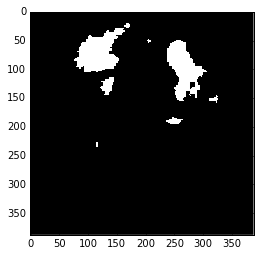

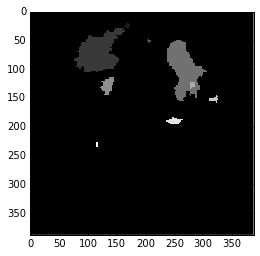

In [27]:
imshow(seg)
imshow(colors,cmap="Spectral")

The following function will compute the average dice between the different structures found in the ground truth and prediction.

It matches one structure in the ground truth to the prediction by simply taking the structure with the closest centroid.

The function returns :

- Average dice found across all structures (with dice 0 for extra structures found in either prediction or ground truth i.e, false positives or false negatives)
- Weight that should be assigned to this avg dice. Actually it's just max(number of structures in segmentation, num of structures in prediction). Therefore it's counting both false positives and false negatives.



In [208]:
import sys
import scipy.spatial.distance
import scipy.ndimage
import scipy.ndimage.measurements
from collections import defaultdict
def dice_separate_lesions(seg,pred, plot=False):
    """Returns Avg dice of lesion structures and weight to assign to this avg dice."""
    #Ignore liver
    if np.unique(seg).size > 2:
        seg[seg==1] = 0
        seg[seg==2] = 1
    if np.unique(pred).size > 2:
        pred[pred==1] = 0
        pred[pred==2] = 1
    # First component is always background
    seg[0,0] = 0
    pred[0,0] = 0
    # Get connected components
    comps_seg, num_comps_seg = scipy.ndimage.label(seg)
    comps_pred, num_comps_pred = scipy.ndimage.label(pred)
    print 'Found n connected components in ground truth (not including bg) :', num_comps_seg
    if plot: imshow(comps_seg, comps_pred, cmap="Spectral", title=['Components in Ground Truth','Components in Prediction'])
    # Get component centroids
    centroids_seg = scipy.ndimage.measurements.center_of_mass(seg, comps_seg, range(1, num_comps_seg+1))
    centroids_pred = scipy.ndimage.measurements.center_of_mass(pred, comps_pred, range(1, num_comps_pred+1))
    # round to nearest 2 decimals (otherwise we might have problems removing from list by-value due to fp inaccuracies)
    centroids_seg = map(lambda t:(round(t[0],2), round(t[1],2)), centroids_seg)
    centroids_pred = map(lambda t:(round(t[0],2), round(t[1],2)), centroids_pred)
    
    def plot_centroids(comps_img, centroids, title, w=5):
        centroid_img = np.ones(comps_img.shape)
        for x,y in centroids:
            centroid_img[x-w:x+w, y-w:y+w] = 0
        plt.title(title)
        plt.imshow(comps_img, cmap="Spectral"); plt.hold(True)
        plt.imshow(centroid_img,cmap="Reds",alpha=0.5)
        plt.show()
    
    
    if plot: plot_centroids(comps_seg, centroids_seg, "Centroids in Ground Truth")
    if plot: plot_centroids(comps_pred, centroids_pred, "Centroids in Prediction")
    
    #### Get Average dice ####
    def get_closest(xy, list_xy, except_at_idx):
        """Returns the index of coordinate in list_xy that is closest to xy (euclidean distance)
        example: get_closest((100,100), [(3,4), (5,9), (101,102), (9999,9999)]) = 2
        because (101,102) is the closest to (100,100).
        except_at_idx is a list of coordinate indices to ignore in list_xy"""
        closest_idx = -1
        min_dist = sys.maxint
        for i, xy_dest in enumerate(list_xy):
            if i in except_at_idx:
                continue
            dist = scipy.spatial.distance.euclidean(xy, xy_dest)
            if dist < min_dist:
                closest_idx = i
                min_dist = dist
        #print xy, map(lambda t:(round(t[0]),round(t[1])),list_xy), closest_idx
        return closest_idx
    
    dices = []
    consumed_lesions_idx = [] #indices of lesions already consumed.
    # Iterate after bg component
    for i in range(num_comps_pred):
        # Add 0 dice to false positives!
        if len(centroids_seg) == 0:
            dices.append(0)
            continue
        current_xy = centroids_pred[i]
        closest_component = get_closest(current_xy, centroids_seg, except_at_idx=consumed_lesions_idx)
        consumed_lesions_idx.append(closest_component)
        #mask out other components 
        one_lesion_pred = np.clip(comps_pred == i, 0, 1)
        one_lesion_seg = np.clip(comps_seg == closest_component, 0, 1)
        dices.append(dice(one_lesion_pred, one_lesion_seg, label_of_interest = 1))
    
    # Add 0 dice for false negatives
    if len(centroids_seg)-len(consumed_lesions_idx) > 0:
        dices.extend([0]*(len(centroids_seg)-len(consumed_lesions_idx)))

    return np.mean(dices), len(dices)

Found n connected components in ground truth (not including bg) : 8


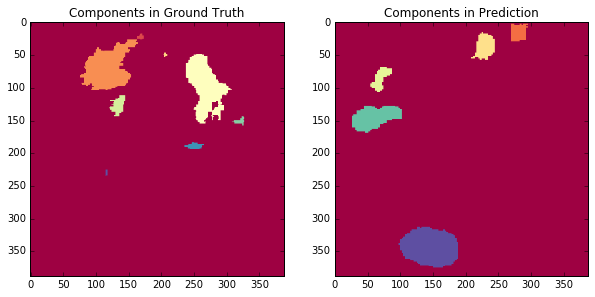

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


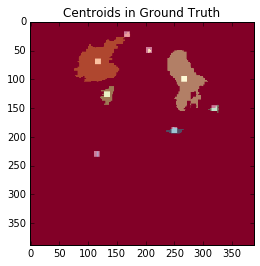

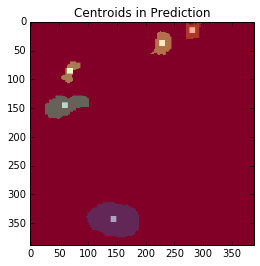

(0.0075440945139116635, 8)

In [209]:
dice_separate_lesions(seg,seg2,plot=True)

Pretty low number because these are just 2 random images just to clarify.

However, there's also one more reason : If the image is not smooth, there will be many individual tiny components, each one will contribute with weight=1 and dice probably 0. So this method DOES NOT WORK unless images are smoothed with CRF or similar, so that the lesions found are of reasonable size and count. Another fix, as Florian suggested, is to weight size of lesion.

Let's see for a perfect segmentation :

Found n connected components in ground truth (not including bg) : 8


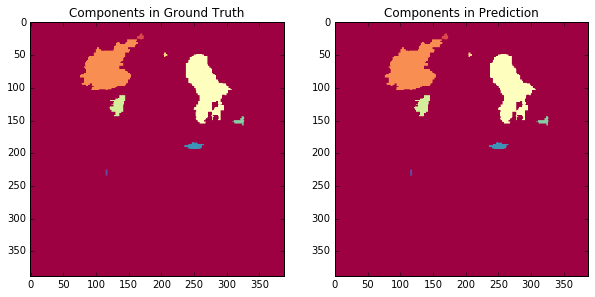

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


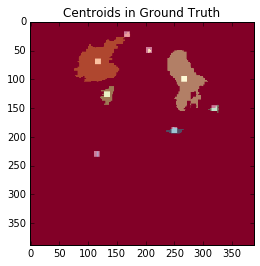

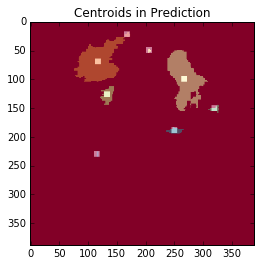

(1.0, 8)

In [210]:
dice_separate_lesions(seg,seg,plot=True)